C:\Users\WDMX\anaconda3\envs\baby\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\WDMX\anaconda3\envs\baby\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


第 0/19 轮训练
----------
train 损失: 1.3913 准确率: 0.5168
test 损失: 0.4038 准确率: 0.8598
第 1/19 轮训练
----------
train 损失: 0.7654 准确率: 0.7263
test 损失: 0.1847 准确率: 0.9634
第 2/19 轮训练
----------
train 损失: 0.6669 准确率: 0.7752
test 损失: 0.2158 准确率: 0.9451
第 3/19 轮训练
----------
train 损失: 0.6045 准确率: 0.7936
test 损失: 0.1646 准确率: 0.9512
第 4/19 轮训练
----------
train 损失: 0.5073 准确率: 0.8211
test 损失: 0.0680 准确率: 0.9878
第 5/19 轮训练
----------
train 损失: 0.5122 准确率: 0.8242
test 损失: 0.1033 准确率: 0.9756
第 6/19 轮训练
----------
train 损失: 0.5418 准确率: 0.8180
test 损失: 0.0839 准确率: 0.9695
第 7/19 轮训练
----------
train 损失: 0.4784 准确率: 0.8196
test 损失: 0.0495 准确率: 0.9939
第 8/19 轮训练
----------
train 损失: 0.4354 准确率: 0.8578
test 损失: 0.0397 准确率: 0.9939
第 9/19 轮训练
----------
train 损失: 0.4035 准确率: 0.8685
test 损失: 0.0366 准确率: 0.9939
第 10/19 轮训练
----------
train 损失: 0.3928 准确率: 0.8685
test 损失: 0.0402 准确率: 0.9878
第 11/19 轮训练
----------
train 损失: 0.3832 准确率: 0.8792
test 损失: 0.0385 准确率: 0.9878
第 12/19 轮训练
----------
train 损失: 0.3806 准确率: 0.886

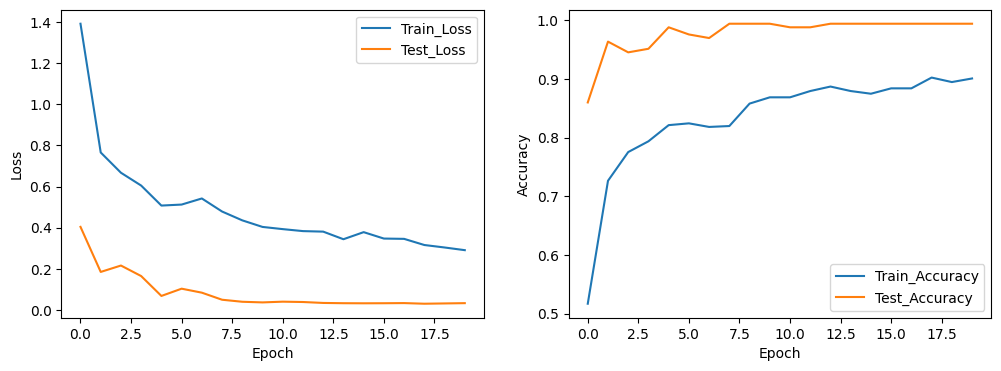

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
import time

# 数据增强与标准化
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# 数据集路径
data_dir = './hpdata'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=16, shuffle=True, num_workers=4)
               for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

# 检查是否可以使用 GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 加载预训练的 ResNet50 模型
model_ft = models.resnet50(pretrained=True)

# 修改最后的全连接层
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

# 将模型移到 GPU 上
model_ft = model_ft.to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_ft.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# 训练模型函数
def train_model(model, criterion, optimizer, num_epochs=25):
    train_loss_history = []
    test_loss_history = []
    train_acc_history = []
    test_acc_history = []
    times = []

    for epoch in range(num_epochs):
        start_time = time.time()
        print(f'第 {epoch}/{num_epochs - 1} 轮训练')
        print('-' * 10)

        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} 损失: {epoch_loss:.4f} 准确率: {epoch_acc:.4f}')

            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc)
            else:
                test_loss_history.append(epoch_loss)
                test_acc_history.append(epoch_acc)

        scheduler.step()
        times.append(time.time() - start_time)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_history, label='Train_Loss')
    plt.plot(test_loss_history, label='Test_Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot([x.cpu().numpy() for x in train_acc_history], label='Train_Accuracy')
    plt.plot([x.cpu().numpy() for x in test_acc_history], label='Test_Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    return model

# 开始训练模型
model = train_model(model_ft, criterion, optimizer, num_epochs=20)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.48189062..0.7163866].


Real-Catogory: Ron Weasley, Predict-Catagory: Ron Weasley


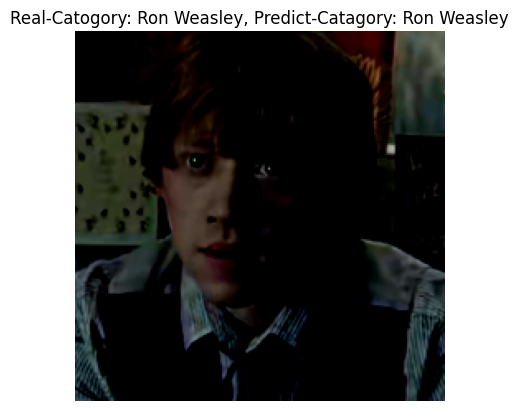

按 Enter 键继续测试下一个样本... 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.44764107..1.1102941].


Real-Catogory: Harry Potter, Predict-Catagory: Harry Potter


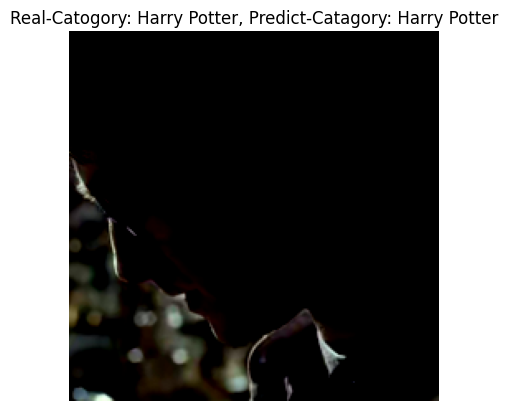

按 Enter 键继续测试下一个样本... 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.8112855].


Real-Catogory: Voldemort, Predict-Catagory: Voldemort


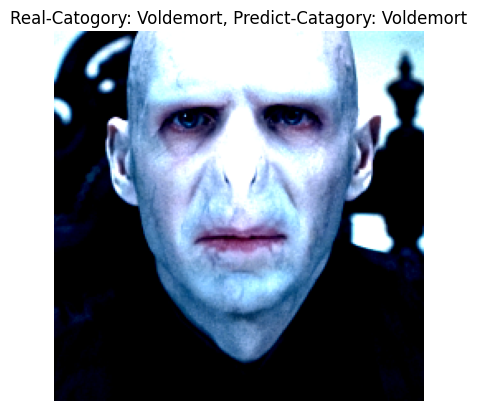

按 Enter 键继续测试下一个样本... 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.55038965..1.2220224].


Real-Catogory: Ron Weasley, Predict-Catagory: Ron Weasley


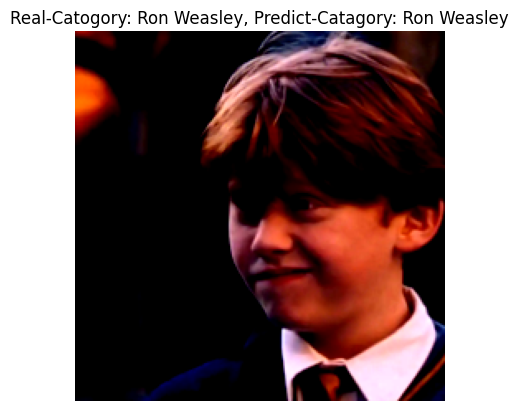

按 Enter 键继续测试下一个样本... 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.45620346..1.3028712].


Real-Catogory: Hermione Granger, Predict-Catagory: Hermione Granger


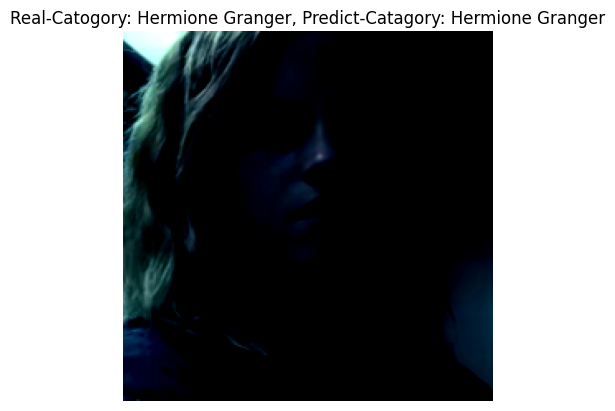

按 Enter 键继续测试下一个样本... 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.55038965..1.6792717].


Real-Catogory: Severus Snape, Predict-Catagory: Severus Snape


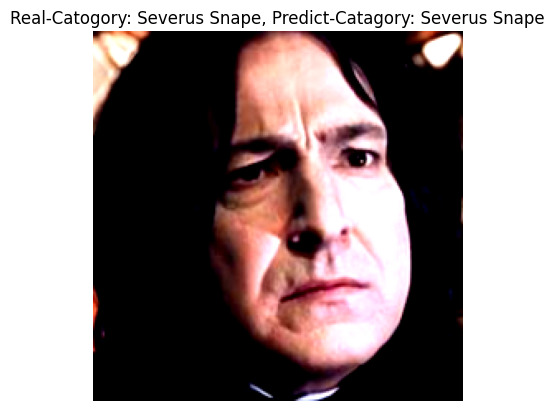

按 Enter 键继续测试下一个样本... 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


Real-Catogory: Albus Dumbledore, Predict-Catagory: Albus Dumbledore


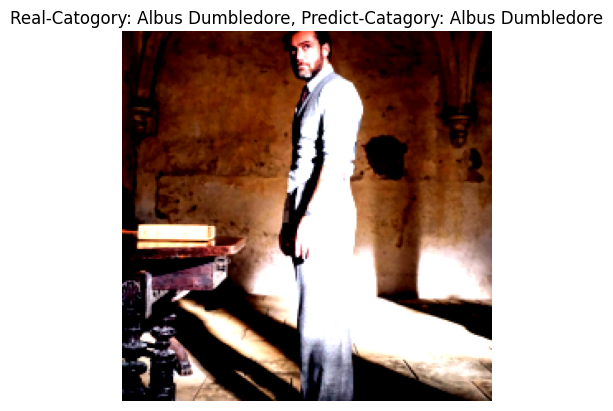

按 Enter 键继续测试下一个样本... 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.46533608..1.6158917].


Real-Catogory: Rubeus Hagrid, Predict-Catagory: Rubeus Hagrid


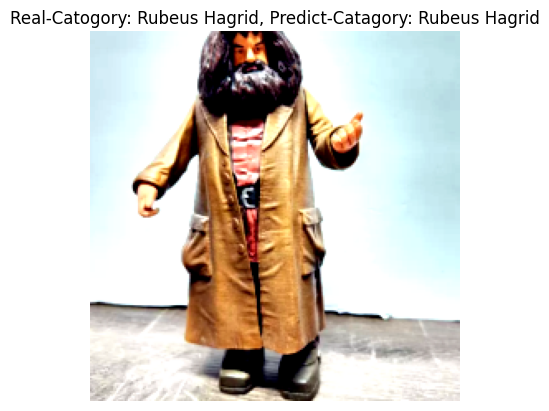

按 Enter 键继续测试下一个样本... 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4390787..0.39952075].


Real-Catogory: Ron Weasley, Predict-Catagory: Ron Weasley


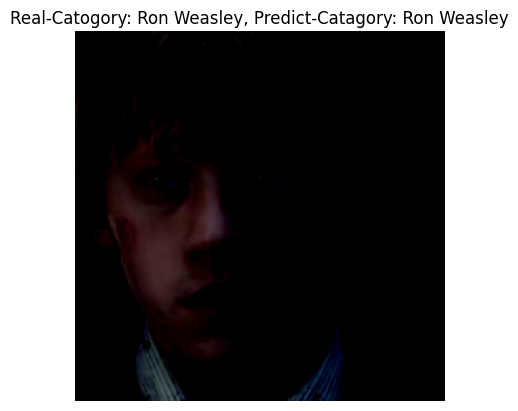

按 Enter 键继续测试下一个样本... 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.6892812].


Real-Catogory: Rubeus Hagrid, Predict-Catagory: Rubeus Hagrid


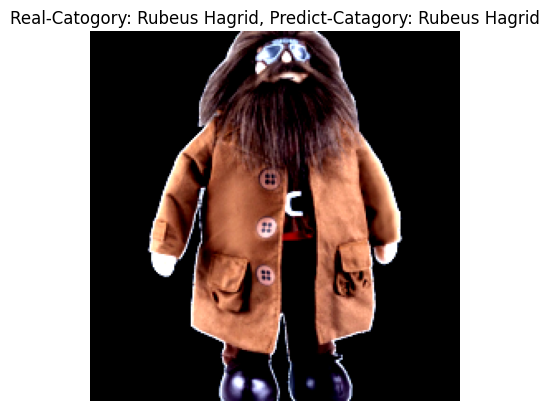

按 Enter 键继续测试下一个样本... 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


Real-Catogory: Severus Snape, Predict-Catagory: Severus Snape


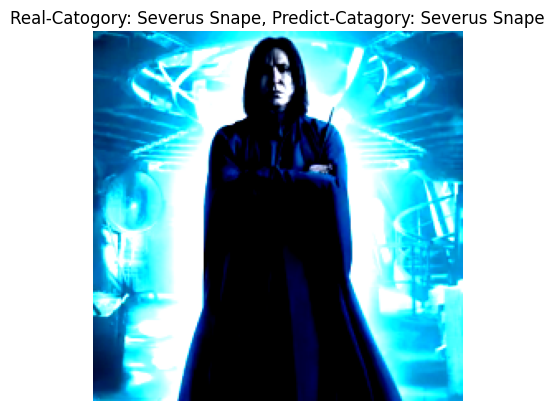

按 Enter 键继续测试下一个样本... 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5075778..1.6544228].


Real-Catogory: Ron Weasley, Predict-Catagory: Ron Weasley


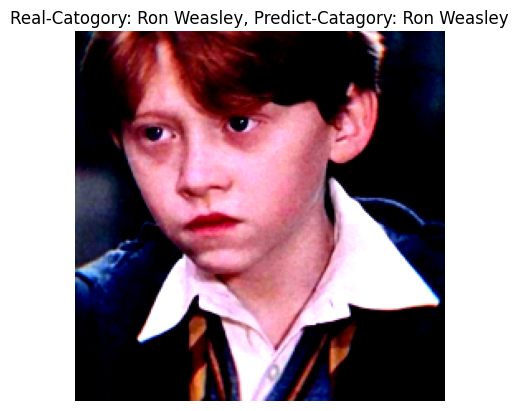

In [ ]:
import random
import torch
import matplotlib.pyplot as plt

# 测试一个随机图片并显示真实名称和预测名称
def imshow(img):
    """展示图像的辅助函数"""
    img = img / 2 + 0.5  # 反标准化，如果训练时是这种标准化方式
    plt.imshow(img.numpy().transpose((1, 2, 0)))  # 转换为 HWC 格式
    plt.axis('off')

# 随机选择的索引列表
indices = list(range(len(image_datasets['test'])))  # 使用 image_datasets['test'] 代替 test_dataset
random.shuffle(indices)  # 打乱索引顺序

# 设置设备（确保和模型训练时一致）
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 逐个测试，直到测试完所有数据
for index in indices:
    sample_image, sample_label = image_datasets['test'][index]  # 根据随机索引获取样本
    sample_image = sample_image.unsqueeze(0)  # 增加一个维度
    
    # 将图像和标签移到相同设备上
    sample_image = sample_image.to(device)

    # 进行推断
    model.eval()  # 设置为评估模式
    with torch.no_grad():
        output = model(sample_image)
        _, predicted = torch.max(output.data, 1)  # 获取最大的预测概率的下标

    # 获取真实类别和预测类别名称
    true_label = sample_label  # 直接使用 sample_label
    predicted_label = predicted.item()  # 取得预测类别的下标

    # 获取类别名称
    true_class_name = class_names[true_label]
    predicted_class_name = class_names[predicted_label]

    # 输出结果
    print(f"Real-Catogory: {true_class_name}, Predict-Catagory: {predicted_class_name}")

    # 显示图像
    plt.figure()
    imshow(sample_image.cpu()[0])  # 转回 CPU 后再显示图像
    plt.title(f"Real-Catogory: {true_class_name}, Predict-Catagory: {predicted_class_name}")
    plt.show()

    # 这里可以选择在显示完一张图像后暂停，等待用户输入继续测试
    input("按 Enter 键继续测试下一个样本...")
